In [1]:
import re
from datetime import datetime

In [2]:
import os
import geopandas as gpd
import geemap
import xml.etree.ElementTree as ET
import pandas as pd
from shapely.geometry import LineString

# constante requerida
namespace = {"kml": "http://www.opengis.net/kml/2.2"}

In [3]:
import geopandas as gpd
from pyproj import CRS
from pykml import parser
from shapely.geometry import Point, LineString

In [4]:
path_rec = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\SHP\RECORRIDOS.shp'
gdf_rec = gpd.read_file(path_rec)

In [5]:
# Directorio donde están los archivos KML
path_kml = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03_kml'
contenido = os.listdir(path_kml)
len(contenido)

3

In [6]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

3

In [7]:
def extraer_fecha(fecha_txt):
    match = re.search(r"([A-Za-z]{3}-\d{1,2}[a-z]{2}-\d{4})", fecha_txt)
    return match.group(1) if match else None

def format_date(date_str):
    try:
        # Eliminar sufijos ordinales para facilitar la conversión
        date_without_suffix = re.sub(r'(st|nd|rd|th)', '', date_str)
        return pd.to_datetime(date_without_suffix, format='%b-%d-%Y').strftime('%d/%m/%Y')
    except:
        return None

def week_number(date_str):
    """
    Retorna el número de semana del año para una fecha dada en formato "dd/mm/aaaa".
    """
    try:
        date_obj = pd.to_datetime(date_str, format='%d/%m/%Y')
        return date_obj.isocalendar()[1]  # El segundo valor de isocalendar() es el número de semana
    except:
        return None

In [8]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

In [9]:
# lista para almacenar nombres de archivo
file_name = []
# lista para alamcenar recorridos
lineas = []

# itera sobre la lista de nombres de archivos
for i in contenido_filtrado:
    # directorio + nombre de archivo
    path = path_kml + '\\' + i
    # leer el arbol de contenido del archivo
    tree = ET.parse(path)
    root = tree.getroot()
    for placemark in root.findall(".//kml:Placemark", namespace):
        coord_text = placemark.find(".//kml:coordinates", namespace).text.strip()
        # obtiene las cooredenadas
        coords = coord_text.split('\n')
        # lista para guardar las coors
        coordinates = []
        # recorre las coors
        for j in coords:
            # split para separa el 3er elemento que acompaña las coors
            coord = j.split(',')
            # agrega las coors a la lista
            coordinates.append((float(coord[0]), float(coord[1])))
    # conviente en DF
    df = pd.DataFrame(coordinates, columns=['Longitude', 'Latitude'])
    # convierte en GDF
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    # convierte el GDF en Linea
    line = LineString(gdf.geometry.tolist())
    # se almacena en listas el nombre del archivo y la geomedia del recorrido
    file_name.append(i)
    lineas.append(line)

In [10]:
# dic con la geometria y el file_name
data_lineas = {
    'nombre': file_name,
    'vehiculo': ['DA03']*len(file_name),
    'geometry': lineas
}

In [11]:
gdf_lineas = gpd.GeoDataFrame(data_lineas)
gdf_lineas.crs = "EPSG:4326"
gdf_lineas = gdf_lineas.to_crs(epsg=32720)
gdf_lineas

,nombre,vehiculo,geometry
0,May-5th-2025-10-56PM-Flight-Airdata.kml,DA03,"LINESTRING (499842.684 8095637.224, 499842.695..."
1,May-5th-2025-11-22PM-Flight-Airdata.kml,DA03,"LINESTRING (499847.001 8095634.027, 499847.001..."
2,May-5th-2025-11-40PM-Flight-Airdata.kml,DA03,"LINESTRING (499846.012 8095635.675, 499846.002..."


<Axes: >

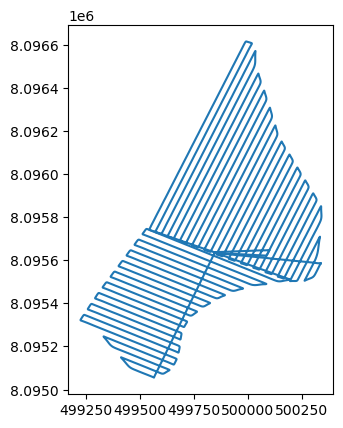

In [12]:
gdf_lineas.plot()

In [13]:
len(gdf_lineas)

3

In [14]:
# Combinar los GeoDataFrames
gdf_combined = gpd.GeoDataFrame(pd.concat([gdf_rec, gdf_lineas], ignore_index=True))
# rellenar valores NaN
gdf_combined['idd'] = gdf_combined['idd'].fillna(0).astype(int)

In [15]:
gdf_combined['num_vert'] = gdf_combined['geometry'].apply(contar_coordenadas)

In [16]:
gdf_combined

,idd,nombre,vehiculo,num_vert,id,asignado,geometry
0,0,2025-05-02 08-32-28.tlog,DA02,2517,None,None,"LINESTRING (471873.745 8084797.248, 471873.415..."
1,0,2025-05-05 16-16-47.tlog,DA02,1056,None,None,"LINESTRING (478886.299 8093597.535, 478886.288..."
2,0,2025-05-05 16-32-05.tlog,DA02,345,None,None,"LINESTRING (478939.004 8093577.919, 478939.004..."
3,0,2025-05-05 21-05-04.tlog,DA02,3426,None,None,"LINESTRING (478661.660 8093836.724, 478660.405..."
4,0,2025-05-05 21-05-04.tlog,DA02,3207,None,None,"LINESTRING (478649.523 8093832.840, 478649.555..."
5,0,2025-05-05 21-05-04.tlog,DA02,2116,None,None,"LINESTRING (479625.362 8093819.537, 479625.373..."
6,0,2025-05-05 21-05-04.tlog,DA02,3745,None,None,"LINESTRING (480504.357 8093555.856, 480504.347..."
7,0,2025-05-05 22-55-05.tlog,DA02,1287,None,None,"LINESTRING (501961.173 8094375.668, 501961.173..."
8,0,2025-05-05 22-55-05.tlog,DA02,2576,None,None,"LINESTRING (501596.537 8094577.716, 501596.548..."
9,0,2025-05-05 22-55-05.tlog,DA02,1149,None,None,"LINESTRING (501591.232 8094578.159, 501591.264..."


In [17]:
gdf_combined.dtypes

idd            int32
nombre        object
vehiculo      object
num_vert       int64
id            object
asignado      object
geometry    geometry
dtype: object

In [18]:
gdf_combined.to_file(path_rec, driver="ESRI Shapefile")